In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

def data_vis(df):
    df['datetime'] = pd.to_datetime(df['datetime'])  # transform the time format
    df = df.sort_values("datetime")  # rank according to the time series

    # load all the sensor channels
    channels = df['channel'].unique()

    # set the font size
    plt.rcParams.update({'font.size': 5})  

    # set the figure size
    fig, axes = plt.subplots(nrows=len(channels), ncols=1, figsize=(6, len(channels) * 1.5), sharex=True)

    if len(channels) == 1:
        axes = [axes]

    # Traverse each channel, drawing the separate subgraph
    for i, channel in enumerate(channels):
        sub_df = df[df['channel'] == channel]  # select the data for a specific channel
        axes[i].plot(sub_df['datetime'], sub_df['value'], label=f"Channel {channel}", color='b')

        # set time format
        axes[i].xaxis.set_major_locator(mdates.HourLocator(interval=12)) # every 12hs
        axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))  # time format

        # Get all scales for the current X-axis
        tick_labels = [label.get_text() for label in axes[i].get_xticklabels()]
    
        # Keep only part of the label, 1 out of every 4 labels
        for j, label in enumerate(axes[i].get_xticklabels()):
            if j % 4 != 0: 
                label.set_visible(False)

        axes[i].set_ylabel("Value")
        axes[i].set_title(f"Time Series for Channel {channel}")
        axes[i].legend()
        axes[i].grid(True)

    # Format the X-axis
    plt.xlabel("Time")
    plt.xticks(rotation=15)  # Rotate the X-axis scale to prevent overlap
    plt.tight_layout()
    plt.show()


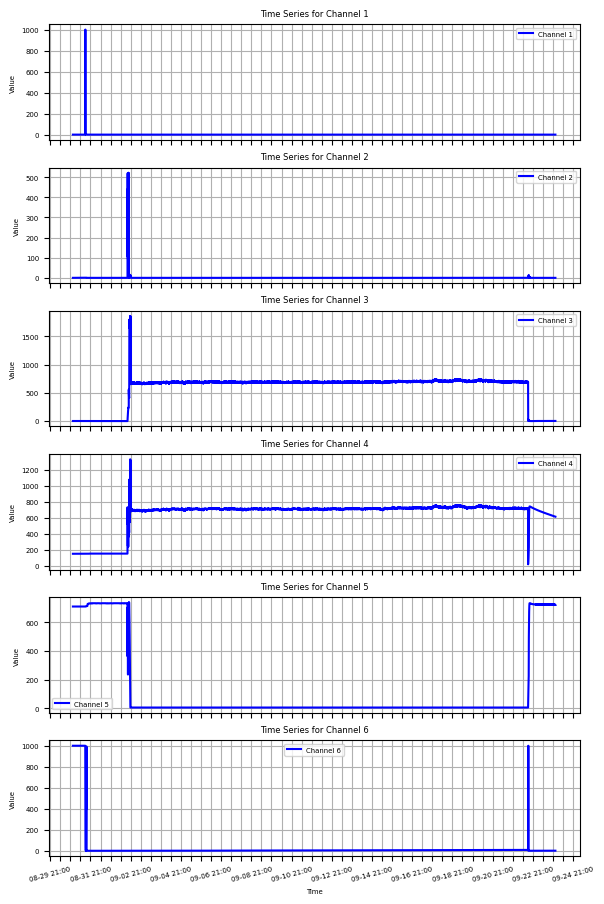

In [1]:
from data_visualization import data_vis
import pandas as pd

df = pd.read_csv("databases/data_csv/cd230831/maxigauge.csv")  # or maxigauge.csv / cooling.csv
data_vis(df)

In [2]:

import pandas as pd

# 读取数据
file_path = "databases/data_csv/cd230831/temperature.csv"
df = pd.read_csv(file_path)

# 确保 datetime 是时间格式
df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce", infer_datetime_format=True)

# 直接筛选某个时间点，看看是否重复
specific_time = "2023-09-05 00:00:06"  # 你可以换成你觉得不重复的时间
df_filtered = df[df["datetime"] == specific_time]

# **直接打印数据**
print(df_filtered)



            id  channel      value            datetime
14872  6611486        1  35.874200 2023-09-05 00:00:06
14875  6611489        2   3.131080 2023-09-05 00:00:06
14878  6611492        5   0.899100 2023-09-05 00:00:06
14881  6611495        6   0.013259 2023-09-05 00:00:06
17148  6613762        1  35.874200 2023-09-05 00:00:06
18224  6614838        2   3.131080 2023-09-05 00:00:06
19300  6615914        5   0.899100 2023-09-05 00:00:06
20376  6616990        6   0.013259 2023-09-05 00:00:06


C:\Users\Gerry\AppData\Local\Temp\ipykernel_8048\1098337775.py:8: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce", infer_datetime_format=True)


In [6]:
import pandas as pd

def process_and_interpolate_time_series(df, time_interval="30S", aggregation_method="mean"):
    """
    处理时间序列数据，去除重复 `datetime + channel` 组合，并进行插值对齐。

    参数:
    df (pd.DataFrame): 包含 id、channel、value 和 datetime 列的原始数据。
    time_interval (str): 重新采样的时间间隔（默认 30 秒，即 "30S"）。
    aggregation_method (str): 处理重复数据的方法（"mean", "max", "min", "first"）。

    返回:
    pd.DataFrame: 处理后的 DataFrame，每个 channel 变成一列，datetime 作为索引。
    """

    # **Step 1: 确保 datetime 是时间格式**
    df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce", infer_datetime_format=True)

    # **Step 2: 处理重复的 `datetime + channel` 组合**
    if aggregation_method == "mean":
        df = df.groupby(["datetime", "channel"], as_index=False).agg({"value": "mean"})
    elif aggregation_method == "max":
        df = df.groupby(["datetime", "channel"], as_index=False).agg({"value": "max"})
    elif aggregation_method == "min":
        df = df.groupby(["datetime", "channel"], as_index=False).agg({"value": "min"})
    elif aggregation_method == "first":
        df = df.drop_duplicates(subset=["datetime", "channel"], keep="first")
    else:
        raise ValueError("Invalid aggregation method. Choose from 'mean', 'max', 'min', 'first'.")

    # **Step 3: 生成完整的时间索引**
    time_range = pd.date_range(start=df["datetime"].min(), 
                               end=df["datetime"].max(), 
                               freq=time_interval)

    # **Step 4: 创建插值结果的 DataFrame**
    df_interpolated = pd.DataFrame({"datetime": time_range})

    # **Step 5: 按 channel 进行插值**
    channels = df["channel"].unique()
    for ch in channels:
        temp_df = df[df["channel"] == ch][["datetime", "value"]].drop_duplicates(subset="datetime")

        # **重新索引并插值，填充空缺值**
        temp_df = temp_df.set_index("datetime").reindex(time_range).interpolate(method="linear").ffill().bfill()

        # **合并结果**
        df_interpolated[f"channel{ch}"] = temp_df["value"]

    return df_interpolated





In [9]:

# **示例用法**
file_path = "databases/data_csv/cd230831/temperature.csv"
df = pd.read_csv(file_path)
# 处理数据并插值
df_interpolated = process_and_interpolate_time_series(df, time_interval="30S", aggregation_method="mean")

# 显示结果
from IPython.display import display
display(df_interpolated)  # Displays the DataFrame in a notebook-friendly format



C:\Users\Gerry\AppData\Local\Temp\ipykernel_8048\1243703574.py:17: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce", infer_datetime_format=True)
C:\Users\Gerry\AppData\Local\Temp\ipykernel_8048\1243703574.py:32: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_range = pd.date_range(start=df["datetime"].min(),


,datetime,channel1,channel2,channel5,channel6
0,2023-08-31 00:00:59,NaN,NaN,NaN,NaN
1,2023-08-31 00:01:29,NaN,NaN,NaN,NaN
2,2023-08-31 00:01:59,NaN,NaN,NaN,NaN
3,2023-08-31 00:02:29,NaN,NaN,NaN,NaN
4,2023-08-31 00:02:59,NaN,NaN,NaN,NaN
...,...,...,...,...,...
69102,2023-09-23 23:51:59,NaN,NaN,NaN,NaN
69103,2023-09-23 23:52:29,NaN,NaN,NaN,NaN
69104,2023-09-23 23:52:59,NaN,NaN,NaN,NaN
69105,2023-09-23 23:53:29,NaN,NaN,NaN,NaN


In [26]:
import pandas as pd
import numpy as np

# 1️⃣ 读取数据
file_path = "databases/data_csv/cd230831/temperature.csv"
df = pd.read_csv(file_path)
df["datetime"] = pd.to_datetime(df["datetime"], format="%Y-%m-%d %H:%M:%S.%f") # 确保 datetime 格式正确
df = df.set_index("datetime")  # 设置 datetime 为索引
print(df.head(20))



                          id  channel    value
datetime                                      
2023-08-31 00:00:59  6596614        1  293.079
2023-08-31 00:01:59  6596615        1  293.081
2023-08-31 00:03:00  6596616        1  293.078
2023-08-31 00:00:59  6596617        2  293.751
2023-08-31 00:01:59  6596618        2  293.752
2023-08-31 00:03:00  6596619        2  293.761
2023-08-31 00:00:59  6596620        5  293.731
2023-08-31 00:01:59  6596621        5  293.709
2023-08-31 00:03:00  6596622        5  293.753
2023-08-31 00:00:59  6596623        6    0.000
2023-08-31 00:01:59  6596624        6    0.000
2023-08-31 00:03:00  6596625        6    0.000
2023-08-31 00:05:00  6596626        1  293.077
2023-08-31 00:05:00  6596627        2  293.743
2023-08-31 00:05:00  6596628        5  293.714
2023-08-31 00:05:00  6596629        6    0.000
2023-08-31 00:08:00  6596630        1  293.073
2023-08-31 00:09:00  6596631        1  293.070
2023-08-31 00:08:00  6596632        2  293.755
2023-08-31 00

In [27]:

# 确保 datetime 是索引
df.index = pd.to_datetime(df.index)  # 确保索引是 datetime 类型

# 1️⃣ 使用 pivot_table 将 channel 作为列
df_pivot = df.pivot_table(index="datetime", columns="channel", values="value")

# 2️⃣ 重命名列名为 "channel1", "channel2" 等
df_pivot.columns = [f"channel{int(col)}" for col in df_pivot.columns]

print(df_pivot)


                     channel1  channel2  channel5  channel6
datetime                                                   
2023-08-31 00:00:59   293.079   293.751   293.731       0.0
2023-08-31 00:01:59   293.081   293.752   293.709       0.0
2023-08-31 00:03:00   293.078   293.761   293.753       0.0
2023-08-31 00:05:00   293.077   293.743   293.714       0.0
2023-08-31 00:08:00   293.073   293.755   293.698       0.0
...                       ...       ...       ...       ...
2023-09-23 23:47:00   283.909   267.741   262.148       0.0
2023-09-23 23:49:00   283.935   267.810   262.213       0.0
2023-09-23 23:51:01   283.952   267.876   262.296       0.0
2023-09-23 23:53:01   283.977   267.937   262.395       0.0
2023-09-23 23:54:01   283.984   267.973   262.407       0.0

[18417 rows x 4 columns]


In [4]:
import pandas as pd

file_path = "databases/data_csv/cd230831/cooling.csv"
df = pd.read_csv(file_path)

# 1️⃣ 确保 datetime 是正确格式
df["datetime"] = pd.to_datetime(df["datetime"], format="%Y-%m-%d %H:%M:%S.%f") 

# 2️⃣ 更新 channel 的值
df["channel"] = df.apply(lambda row: 0 if (row["channel"] == 0 and row["io"] == 0) else
                                    1 if (row["channel"] == 0 and row["io"] == 1) else
                                   10 if (row["channel"] == 1 and row["io"] == 0) else
                                   11, axis=1)

# 3️⃣ 只保留所需的列
df = df[["datetime", "channel", "value"]]

# 5️⃣ 显示最终结果
print(df)

                 datetime  channel     value
0     2023-08-31 00:00:34        1  15.55833
1     2023-08-31 00:00:34        0  15.59667
2     2023-08-31 00:00:34       11  15.55556
3     2023-08-31 00:00:34       10  15.54278
4     2023-08-31 00:01:34        1  15.55833
...                   ...      ...       ...
75847 2023-09-23 23:53:34       10  15.54000
75848 2023-09-23 23:55:34        1  15.56056
75849 2023-09-23 23:55:34        0  15.58889
75850 2023-09-23 23:55:34       11  15.54278
75851 2023-09-23 23:55:34       10  15.50944

[75852 rows x 3 columns]


In [ ]:
import pandas as pd
import numpy as np

# 1️⃣ 读取数据
file_path = "databases/data_csv/cd230831/temperature.csv"
df = pd.read_csv(file_path)
df["datetime"] = pd.to_datetime(df["datetime"], format="%Y-%m-%d %H:%M:%S.%f") # 确保 datetime 格式正确
df = df.set_index("datetime")  # 设置 datetime 为索引

# 确保 datetime 是索引
df.index = pd.to_datetime(df.index)  # 确保索引是 datetime 类型

# 1️⃣ 使用 pivot_table 将 channel 作为列
df_pivot = df.pivot_table(index="datetime", columns="channel", values="value")

# 2️⃣ 重命名列名为 "channel1", "channel2" 等
df_pivot.columns = [f"channel{int(col)}" for col in df_pivot.columns]

# 1️⃣ 读取数据
df_pivot.index = pd.to_datetime(df_pivot.index)  # 确保索引是 datetime 类型

# 2️⃣ 获取起点时间
start_time = df_pivot.index.min()  # 第一个时间点
end_time = df_pivot.index.max()  # 原始数据最后时间点

# 3️⃣ 生成新的时间序列，每 30 秒一个点
new_time_stamps = [start_time]  # 存储新时间戳
while new_time_stamps[-1] + pd.Timedelta(seconds=30) <= end_time:
    new_time_stamps.append(new_time_stamps[-1] + pd.Timedelta(seconds=30))

# 4️⃣ 创建新 DataFrame，并进行插值
new_df = pd.DataFrame({"datetime": new_time_stamps})  # 生成 DataFrame

# 5️⃣ 对每个 channel 进行插值
for col in df_pivot.columns:
    new_df[col] = np.interp(
        new_df["datetime"].astype(int),  # 新时间序列的数值表示
        df_pivot.index.astype(int),  # 原始时间的数值表示
        df_pivot[col]  # 原始值
    )

# 6️⃣ 设置索引
new_df.set_index("datetime", inplace=True)

print(new_df.head)


<bound method NDFrame.head of                        channel1    channel2    channel5  channel6
datetime                                                         
2023-08-31 00:00:59  293.079000  293.751000  293.731000       0.0
2023-08-31 00:01:29  293.080000  293.751500  293.720000       0.0
2023-08-31 00:01:59  293.081000  293.752000  293.709000       0.0
2023-08-31 00:02:29  293.079525  293.756426  293.730639       0.0
2023-08-31 00:02:59  293.078049  293.760852  293.752279       0.0
...                         ...         ...         ...       ...
2023-09-23 23:51:59  283.964083  267.905483  262.343850       0.0
2023-09-23 23:52:29  283.970333  267.920733  262.368600       0.0
2023-09-23 23:52:59  283.976583  267.935983  262.393350       0.0
2023-09-23 23:53:29  283.980267  267.953800  262.400600       0.0
2023-09-23 23:53:59  283.983767  267.971800  262.406600       0.0

[69107 rows x 4 columns]>
